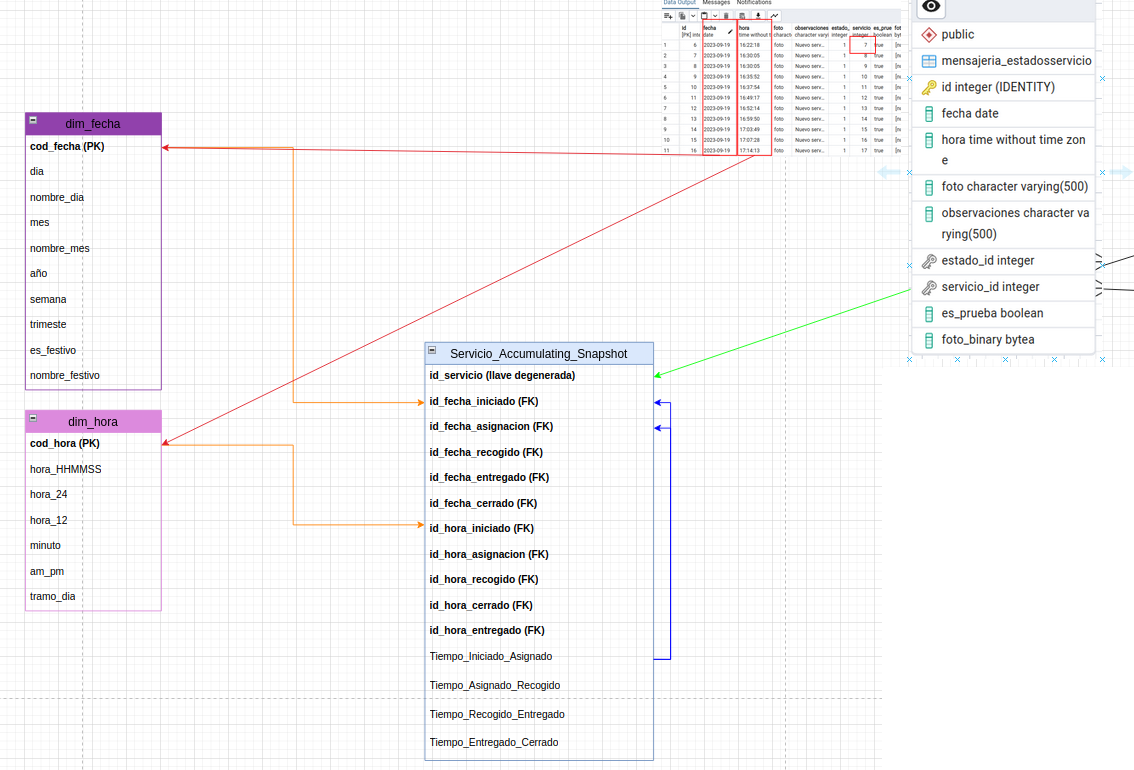

## Importar librerías

In [1]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct
from datetime import datetime
import numpy as np

## Conexión con base de datos

In [2]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

In [3]:
# Leer los datos de las tablas

# De la fuente
definicion_estados_df = pd.read_sql_table("mensajeria_estado", con=engine_src)
estados_servicio = pd.read_sql_table("mensajeria_estadosservicio", con=engine_src)

# Del Warehouse
dim_fecha = pd.read_sql_table("dim_fecha", con=engine_etl)
dim_hora = pd.read_sql_table("dim_hora", con=engine_etl)

In [4]:
# Comprobar los campos
definicion_estados_df.info()
definicion_estados_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6 non-null      int64 
 1   nombre       6 non-null      object
 2   descripcion  6 non-null      object
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes


,id,nombre,descripcion
0,4,Recogido por mensajero,Recogido por mensajero
1,5,Entregado en destino,Entregado en destino
2,3,Con novedad,Tiene novedad
3,6,Terminado completo,Terminado completo
4,1,Iniciado,Creado por el usuario
5,2,Con mensajero Asignado,Con mensajero Asignado


In [5]:
# Comprobar los campos
estados_servicio.info()
estados_servicio.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128402 entries, 0 to 128401
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             128402 non-null  int64         
 1   fecha          128402 non-null  datetime64[ns]
 2   hora           128402 non-null  object        
 3   foto           128402 non-null  object        
 4   observaciones  128401 non-null  object        
 5   estado_id      128402 non-null  int64         
 6   servicio_id    128402 non-null  int64         
 7   es_prueba      128402 non-null  bool          
 8   foto_binary    270 non-null     object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 8.0+ MB


,id,fecha,hora,foto,observaciones,estado_id,servicio_id,es_prueba,foto_binary
0,1014,2024-01-29,01:13:32,foto,4 tubos,4,226,False,None
1,1484,2024-01-30,18:45:12,foto,Demora,3,79,True,None
2,2829,2024-02-06,11:34:04,foto,Compra exitosa,5,613,False,None


In [6]:
# Comprobar los campos
dim_fecha.info()
dim_fecha.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key_fecha      669 non-null    int64         
 1   date           669 non-null    datetime64[ns]
 2   date_mmdd      669 non-null    object        
 3   date_yyyymmdd  669 non-null    object        
 4   day            669 non-null    int64         
 5   day_of_week    669 non-null    int64         
 6   month          669 non-null    int64         
 7   month_name     669 non-null    object        
 8   year           669 non-null    int64         
 9   week_of_month  669 non-null    int64         
 10  quarter        669 non-null    int64         
 11  is_holiday     669 non-null    bool          
 12  holiday_name   32 non-null     object        
 13  is_leap_year   669 non-null    bool          
dtypes: bool(2), datetime64[ns](1), int64(7), object(4)
memory usage: 64.2+ KB


,key_fecha,date,date_mmdd,date_yyyymmdd,day,day_of_week,month,month_name,year,week_of_month,quarter,is_holiday,holiday_name,is_leap_year
0,0,2023-01-01,01/01,2023/01/01,1,6,1,january,2023,1,1,True,Año Nuevo,False
1,1,2023-01-02,01/02,2023/01/02,2,0,1,january,2023,1,1,False,None,False
2,2,2023-01-03,01/03,2023/01/03,3,1,1,january,2023,1,1,False,None,False


In [7]:
# Comprobar los campos
dim_hora.info()
dim_hora.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key_hora     1440 non-null   int64 
 1   hour_HHMMSS  1440 non-null   object
 2   hour_24      1440 non-null   int64 
 3   hour_12      1440 non-null   int64 
 4   minute       1440 non-null   int64 
 5   am_pm        1440 non-null   object
 6   day_section  1440 non-null   object
dtypes: int64(4), object(3)
memory usage: 78.9+ KB


,key_hora,hour_HHMMSS,hour_24,hour_12,minute,am_pm,day_section
0,0,00:00:00,0,12,0,AM,Madrugada
1,1,00:01:00,0,12,1,AM,Madrugada
2,2,00:02:00,0,12,2,AM,Madrugada


## Transform: Ajustes de la dimensión

### Extraer solo los datos necesarios de la fuente

In [8]:
# Copia los datos necesarios en el DataFrame
servicio_df = estados_servicio[
    [
        "servicio_id",
        "estado_id" ,
        "fecha",
        "hora",
    ]
].copy()

# Convertir 'fecha' a formato de solo fecha
servicio_df["fecha"] = pd.to_datetime(servicio_df["fecha"]).dt.date

# Asegurar que los segundos sean '00' y formatear 'hora' en formato de 24 horas
servicio_df["hora"] = servicio_df["hora"].apply(
    lambda x: x.replace(second=0).strftime("%H:%M:%S") if pd.notnull(x) else None
)

servicio_df.head(3)

,servicio_id,estado_id,fecha,hora
0,226,4,2024-01-29,01:13:00
1,79,3,2024-01-30,18:45:00
2,613,5,2024-02-06,11:34:00


### Realizar JOIN con dimensiones para cada tipo de fecha y hora del `hecho`

In [9]:
definicion_estados_df.head(10)

,id,nombre,descripcion
0,4,Recogido por mensajero,Recogido por mensajero
1,5,Entregado en destino,Entregado en destino
2,3,Con novedad,Tiene novedad
3,6,Terminado completo,Terminado completo
4,1,Iniciado,Creado por el usuario
5,2,Con mensajero Asignado,Con mensajero Asignado


In [10]:
# Combinar las tablas para obtener los textos de los estados
merged_df = servicio_df.merge(
    definicion_estados_df,
    how="left",
    left_on="estado_id",
    right_on="id",
    suffixes=("", "_estado"),
)

merged_df.head(3)

,servicio_id,estado_id,fecha,hora,id,nombre,descripcion
0,226,4,2024-01-29,01:13:00,4,Recogido por mensajero,Recogido por mensajero
1,79,3,2024-01-30,18:45:00,3,Con novedad,Tiene novedad
2,613,5,2024-02-06,11:34:00,5,Entregado en destino,Entregado en destino


In [11]:
# Limpiar para obtener solo los campos necesarios
merged_df = merged_df[["servicio_id", "nombre", "fecha", "hora"]]
merged_df.rename(columns={"nombre": "nombre_estado"}, inplace=True)

merged_df.head(3)

,servicio_id,nombre_estado,fecha,hora
0,226,Recogido por mensajero,2024-01-29,01:13:00
1,79,Con novedad,2024-01-30,18:45:00
2,613,Entregado en destino,2024-02-06,11:34:00


In [12]:
dim_fecha.head(1)

,key_fecha,date,date_mmdd,date_yyyymmdd,day,day_of_week,month,month_name,year,week_of_month,quarter,is_holiday,holiday_name,is_leap_year
0,0,2023-01-01,01/01,2023/01/01,1,6,1,january,2023,1,1,True,Año Nuevo,False


In [13]:
# Asegúrate de que 'fecha' en merged_df sea del mismo tipo que 'date' en dim_fecha
merged_df["fecha"] = pd.to_datetime(
    merged_df["fecha"], format="%Y-%m-%d", errors="coerce"
)
dim_fecha["date"] = pd.to_datetime(
    dim_fecha["date"], format="%Y-%m-%d", errors="coerce"
)

# Combina con dim_fecha
merged_df = merged_df.merge(
    dim_fecha, how="left", left_on="fecha", right_on="date", suffixes=("", "_fecha")
)

# Nos quedamos solo con los campos de fecha relevantes
merged_df = merged_df[["servicio_id", "nombre_estado", "key_fecha", "date", "hora"]]
merged_df.rename(columns={"date": "dim_fecha_date"}, inplace=True)

merged_df.head(10)

,servicio_id,nombre_estado,key_fecha,dim_fecha_date,hora
0,226,Recogido por mensajero,393,2024-01-29,01:13:00
1,79,Con novedad,394,2024-01-30,18:45:00
2,613,Entregado en destino,401,2024-02-06,11:34:00
3,376,Recogido por mensajero,396,2024-02-01,14:50:00
4,7164,Con novedad,461,2024-04-06,16:11:00
5,377,Con novedad,399,2024-02-04,11:15:00
6,10910,Con novedad,488,2024-05-03,06:11:00
7,746,Con mensajero Asignado,402,2024-02-07,16:26:00
8,842,Terminado completo,404,2024-02-09,13:25:00
9,930,Con mensajero Asignado,405,2024-02-10,13:46:00


In [14]:
dim_hora.head(1)

,key_hora,hour_HHMMSS,hour_24,hour_12,minute,am_pm,day_section
0,0,00:00:00,0,12,0,AM,Madrugada


In [15]:
# Combina con dim_hora
merged_df = merged_df.merge(
    dim_hora,
    how="left",
    left_on="hora",
    right_on="hour_HHMMSS",
    suffixes=("", "_hora"),
)

# Nos quedamos solo con los campos de fecha relevantes
merged_df = merged_df[
    [
        "servicio_id",
        "nombre_estado",
        "key_fecha",
        "dim_fecha_date",
        "key_hora",
        "hour_HHMMSS",
    ]
]
merged_df.rename(columns={"hour_HHMMSS": "dim_hora_hour_HHMMSS"}, inplace=True)

merged_df.head(10)

,servicio_id,nombre_estado,key_fecha,dim_fecha_date,key_hora,dim_hora_hour_HHMMSS
0,226,Recogido por mensajero,393,2024-01-29,73,01:13:00
1,79,Con novedad,394,2024-01-30,1125,18:45:00
2,613,Entregado en destino,401,2024-02-06,694,11:34:00
3,376,Recogido por mensajero,396,2024-02-01,890,14:50:00
4,7164,Con novedad,461,2024-04-06,971,16:11:00
5,377,Con novedad,399,2024-02-04,675,11:15:00
6,10910,Con novedad,488,2024-05-03,371,06:11:00
7,746,Con mensajero Asignado,402,2024-02-07,986,16:26:00
8,842,Terminado completo,404,2024-02-09,805,13:25:00
9,930,Con mensajero Asignado,405,2024-02-10,826,13:46:00


In [16]:
definicion_estados_df.head(10)

,id,nombre,descripcion
0,4,Recogido por mensajero,Recogido por mensajero
1,5,Entregado en destino,Entregado en destino
2,3,Con novedad,Tiene novedad
3,6,Terminado completo,Terminado completo
4,1,Iniciado,Creado por el usuario
5,2,Con mensajero Asignado,Con mensajero Asignado


In [17]:
# Ejemplo de un servicio ya completado
# Filtrar los registros donde servicio_id es igual a 842
merged_df[merged_df["servicio_id"] == 842] # ["dim_fecha_date"].values[0]

,servicio_id,nombre_estado,key_fecha,dim_fecha_date,key_hora,dim_hora_hour_HHMMSS
8,842,Terminado completo,404,2024-02-09,805,13:25:00
4316,842,Iniciado,404,2024-02-09,589,09:49:00
4386,842,Con mensajero Asignado,404,2024-02-09,680,11:20:00
4387,842,Recogido por mensajero,404,2024-02-09,681,11:21:00
4432,842,Entregado en destino,404,2024-02-09,799,13:19:00


In [18]:
class Estado:
    def __init__(self, nombre, fecha, hora):
        self.nombre = nombre
        self.fecha = fecha
        self.hora = hora

estados = [
    Estado("Iniciado", "fecha_iniciado", "hora_iniciado"),
    Estado("Con mensajero Asignado", "fecha_asignado", "hora_asignado"),
    Estado("Recogido por mensajero", "fecha_recogido", "hora_recogido"),
    Estado("Entregado en destino", "fecha_entregado", "hora_entregado"),
    Estado("Terminado completo", "fecha_cerrado", "hora_cerrado"),
]

def calcular_diferencia_en_minutos(fecha_inicio, hora_inicio, fecha_fin, hora_fin):
    if (
        fecha_inicio is None
        or hora_inicio is None
        or fecha_fin is None
        or hora_fin is None
    ):
        return None

    # Comparar fechas
    diferencia_dias = (pd.to_datetime(fecha_fin) - pd.to_datetime(fecha_inicio)).days

    # Comparar horas
    hora_inicio_total = sum(
        x * int(t) for x, t in zip([3600, 60, 1], hora_inicio.split(":"))
    )
    hora_fin_total = sum(x * int(t) for x, t in zip([3600, 60, 1], hora_fin.split(":")))

    diferencia_horas = hora_fin_total - hora_inicio_total

    # Total en minutos
    total_diferencia = (
        (diferencia_dias * 24 * 60) + (diferencia_horas // 60) + (diferencia_horas % 60)
    )
    return total_diferencia


data_hecho = [] # Lista para almacenar los datos del hecho
servicios_unicos = merged_df["servicio_id"].unique()[:50] # Obtener los ids

total_servicios = len(servicios_unicos)
print(f"Servicios únicos encontrados: {total_servicios}")

for index, servicio_id in enumerate(servicios_unicos, start=1):

    print(f"Procesando servicio_id: {servicio_id} ({index} de {total_servicios})")

    servicio_data = {}
    registros_servicio = merged_df[merged_df["servicio_id"] == servicio_id]

    if registros_servicio.empty:
        continue  # Saltar a la siguiente iteración si no hay registros

    servicio_data["id_servicio"] = servicio_id

    # Llenar servicio_data con valores de fecha y hora si existen
    for estado in estados:

        id_fecha = registros_servicio[
            registros_servicio["nombre_estado"] == estado.nombre
        ]["key_fecha"].values

        fecha = registros_servicio[
            registros_servicio["nombre_estado"] == estado.nombre
        ]["dim_fecha_date"].values

        id_hora = registros_servicio[registros_servicio["nombre_estado"] == estado.nombre][
            "key_hora"
        ].values

        hora = registros_servicio[
                registros_servicio["nombre_estado"] == estado.nombre
            ]["dim_hora_hour_HHMMSS"].values

        # Colocar la fecha si existe, si no poner None
        servicio_data[f"id_{estado.fecha}"] = id_fecha[0] if len(id_fecha) > 0 else None
        servicio_data[f"{estado.fecha}"] = fecha[0] if len(fecha) > 0 else None

        # Colocar la hora si existe, si no poner None
        servicio_data[f"id_{estado.hora}"] = id_hora[0] if len(id_hora) > 0 else None
        servicio_data[f"{estado.hora}"] = hora[0] if len(hora) > 0 else None

    # Calcular diferencias de tiempo en minutos entre estados
    servicio_data[f"tiempo_iniciado_asignado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_iniciado"],
        servicio_data["hora_iniciado"],
        servicio_data["fecha_asignado"],
        servicio_data["hora_asignado"],
    )

    servicio_data[f"tiempo_asignado_recogido_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_asignado"],
        servicio_data["hora_asignado"],
        servicio_data["fecha_recogido"],
        servicio_data["hora_recogido"],
    )

    servicio_data[f"tiempo_recogido_entregado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_recogido"],
        servicio_data["hora_recogido"],
        servicio_data["fecha_entregado"],
        servicio_data["hora_entregado"],
    )

    servicio_data[f"tiempo_entregado_cerrado_min"] = calcular_diferencia_en_minutos(
        servicio_data["fecha_entregado"],
        servicio_data["hora_entregado"],
        servicio_data["fecha_cerrado"],
        servicio_data["hora_cerrado"],
    )

    # Eliminar columnas de fechas y horas explicitas
    servicio_data.pop("fecha_iniciado", None)
    servicio_data.pop("hora_iniciado", None)
    servicio_data.pop("fecha_asignado", None)
    servicio_data.pop("hora_asignado", None)
    servicio_data.pop("fecha_recogido", None)
    servicio_data.pop("hora_recogido", None)
    servicio_data.pop("fecha_entregado", None)   
    servicio_data.pop("hora_entregado", None)
    servicio_data.pop("fecha_cerrado", None)   
    servicio_data.pop("hora_cerrado", None)

    data_hecho.append(servicio_data)

data_hecho_df = pd.DataFrame(data_hecho)

data_hecho_df.head(5)

Servicios únicos encontrados: 50
Procesando servicio_id: 226 (1 de 50)
Procesando servicio_id: 79 (2 de 50)
Procesando servicio_id: 613 (3 de 50)
Procesando servicio_id: 376 (4 de 50)
Procesando servicio_id: 7164 (5 de 50)
Procesando servicio_id: 377 (6 de 50)
Procesando servicio_id: 10910 (7 de 50)
Procesando servicio_id: 746 (8 de 50)
Procesando servicio_id: 842 (9 de 50)
Procesando servicio_id: 930 (10 de 50)
Procesando servicio_id: 974 (11 de 50)
Procesando servicio_id: 991 (12 de 50)
Procesando servicio_id: 1093 (13 de 50)
Procesando servicio_id: 1123 (14 de 50)
Procesando servicio_id: 1160 (15 de 50)
Procesando servicio_id: 1324 (16 de 50)
Procesando servicio_id: 1424 (17 de 50)
Procesando servicio_id: 1670 (18 de 50)
Procesando servicio_id: 1691 (19 de 50)
Procesando servicio_id: 1735 (20 de 50)
Procesando servicio_id: 1884 (21 de 50)
Procesando servicio_id: 1902 (22 de 50)
Procesando servicio_id: 2028 (23 de 50)
Procesando servicio_id: 2117 (24 de 50)
Procesando servicio_id: 25

,id_servicio,id_fecha_iniciado,id_hora_iniciado,id_fecha_asignado,id_hora_asignado,id_fecha_recogido,id_hora_recogido,id_fecha_entregado,id_hora_entregado,id_fecha_cerrado,id_hora_cerrado,tiempo_iniciado_asignado_min,tiempo_asignado_recogido_min,tiempo_recogido_entregado_min,tiempo_entregado_cerrado_min
0,226,392,1437,393,27,393,73,393.0,99.0,NaN,NaN,30,46,26.0,NaN
1,79,364,820,367,977,367,1179,394.0,1124.0,394.0,1125.0,4477,202,38825.0,1.0
2,613,401,635,401,642,401,660,401.0,694.0,401.0,706.0,7,18,34.0,12.0
3,376,395,1252,396,890,396,890,396.0,890.0,NaN,NaN,1078,0,0.0,NaN
4,7164,461,961,461,970,461,1036,461.0,1117.0,NaN,NaN,9,66,81.0,NaN


In [19]:
# Ejemplo de un servicio ya completado
merged_df[merged_df["servicio_id"] == 842].head()

,servicio_id,nombre_estado,key_fecha,dim_fecha_date,key_hora,dim_hora_hour_HHMMSS
8,842,Terminado completo,404,2024-02-09,805,13:25:00
4316,842,Iniciado,404,2024-02-09,589,09:49:00
4386,842,Con mensajero Asignado,404,2024-02-09,680,11:20:00
4387,842,Recogido por mensajero,404,2024-02-09,681,11:21:00
4432,842,Entregado en destino,404,2024-02-09,799,13:19:00


In [20]:
# Comparacion con la tabla obtenida
data_hecho_df[data_hecho_df["id_servicio"] == 842].head()

,id_servicio,id_fecha_iniciado,id_hora_iniciado,id_fecha_asignado,id_hora_asignado,id_fecha_recogido,id_hora_recogido,id_fecha_entregado,id_hora_entregado,id_fecha_cerrado,id_hora_cerrado,tiempo_iniciado_asignado_min,tiempo_asignado_recogido_min,tiempo_recogido_entregado_min,tiempo_entregado_cerrado_min
8,842,404,589,404,680,404,681,404.0,799.0,404.0,805.0,91,1,118.0,6.0


## Load: Ejecución de ETL

In [21]:
# hecho_servicio_accumulating_snap = pd.merge(mensajeria_estadosservicio_df, mensajeria_estado_df, on="id", how="left")